In [1]:
import pandas
import datetime
import math
import os
import numpy
from scipy import signal, ndimage
from davitpy.models import *
from davitpy import utils
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

In [2]:
def convert_to_datetime(row):
    currDateStr = str( int( row["dateStr"] ) )
#     return currDateStr
    if row["timeStr"] < 10:
        currTimeStr = "000" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 100:
        currTimeStr = "00" + str( int( row["timeStr"] ) )
    elif row["timeStr"] < 1000:
        currTimeStr = "0" + str( int( row["timeStr"] ) )
    else:
        currTimeStr = str( int( row["timeStr"] ) )
    return datetime.datetime.strptime( currDateStr\
                    + ":" + currTimeStr, "%Y%m%d:%H%M" )

selDT = datetime.datetime( 2011, 4, 9, 9, 0 )
anlyzCoords = 'mag'

In [3]:
inpColList = [ "dateStr", "timeStr", "Mlat",\
              "Mlon", "med_tec", "dlat", "dlon" ]
inpFile = "/home/bharat/Documents/"+\
            "medFiltTec/tec-medFilt-20110409.txt"
medFiltTECDF = pandas.read_csv(inpFile, delim_whitespace=True,\
                                    header=None, names=inpColList)
medFiltTECDF["date"] = medFiltTECDF.apply( convert_to_datetime, axis=1 )
medFiltTECDF.head()

,dateStr,timeStr,Mlat,Mlon,med_tec,dlat,dlon,date
0,20110409,800,11.0,34.0,4.9,1.0,2.0,2011-04-09 08:00:00
1,20110409,800,11.0,36.0,7.2,1.0,2.0,2011-04-09 08:00:00
2,20110409,800,11.0,38.0,7.3,1.0,2.0,2011-04-09 08:00:00
3,20110409,800,11.0,64.0,19.0,1.0,2.0,2011-04-09 08:00:00
4,20110409,800,11.0,66.0,19.3,1.0,2.0,2011-04-09 08:00:00


In [4]:
# Analyze the selected time
selTecDF = medFiltTECDF[ medFiltTECDF["date"] == selDT ].reset_index(drop=True)
selTecDF.head()

,dateStr,timeStr,Mlat,Mlon,med_tec,dlat,dlon,date
0,20110409,900,11.0,32.0,10.8,1.0,2.0,2011-04-09 09:00:00
1,20110409,900,11.0,34.0,11.9,1.0,2.0,2011-04-09 09:00:00
2,20110409,900,11.0,70.0,33.0,1.0,2.0,2011-04-09 09:00:00
3,20110409,900,11.0,72.0,34.0,1.0,2.0,2011-04-09 09:00:00
4,20110409,900,11.0,74.0,34.8,1.0,2.0,2011-04-09 09:00:00


In [8]:
# Get the estimated boundaries
fltdTrghLocFname = "../data/newFltrdTrghLoc.txt"
fltTecDataDF = pandas.read_csv(fltdTrghLocFname, sep=' ',\
                            parse_dates=["date"],\
                               infer_datetime_format=True)
selBndDF = fltTecDataDF[ fltTecDataDF["date"] == selDT ].reset_index(drop=True)
selBndDF.head()

,BndEquMlat,BndEquTecVal,BndMlon,BndPolMlat,BndPolTecVal,date,minFltrdTecVal,minTecMlat,minTecVal
0,51.0,21.0,160.0,64.0,20.0,2011-04-09 09:00:00,19.395730,62.0,19.5
1,47.0,22.5,190.0,59.0,22.0,2011-04-09 09:00:00,20.664141,51.0,16.4
2,46.0,22.5,192.0,57.0,22.5,2011-04-09 09:00:00,20.099895,51.0,16.4
3,56.0,8.8,240.0,63.0,7.5,2011-04-09 09:00:00,5.829763,60.0,4.0
4,56.0,8.8,242.0,62.0,7.5,2011-04-09 09:00:00,4.971493,59.0,3.9


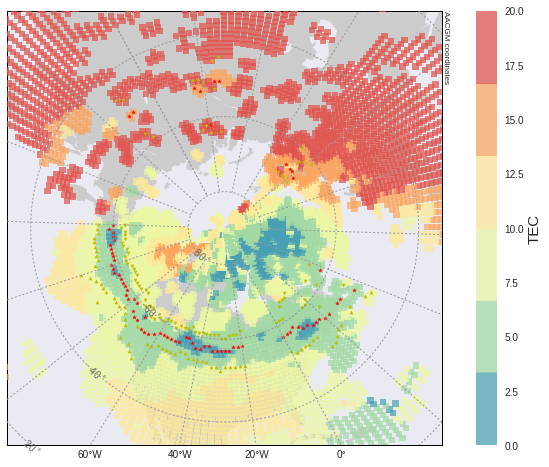

In [11]:
# set colorbar
seaMap = ListedColormap(sns.color_palette("Spectral_r"))
# flatui = ["#3182bd", "#9ecae1", "#7fcdbb", "#ffeda0", "#feb24c", "#f03b20"]
# sns.set_palette(flatui)
# seaMap = ListedColormap( sns.color_palette() )
# Plot map
f = plt.figure(figsize=(12, 8))
ax = f.add_subplot(1,1,1)
m1 = utils.plotUtils.mapObj(boundinglat=30., gridLabels=True, coords=anlyzCoords, ax=ax, datetime=selDT)
xVec, yVec = m1(list(selTecDF["Mlon"]), list(selTecDF["Mlat"]), coords=anlyzCoords)
# BND data
xVecEquBnd, yVecEquBnd = m1(list(selBndDF["BndMlon"]), list(selBndDF["BndEquMlat"]), coords="mag")
xVecPolBnd, yVecPolBnd = m1(list(selBndDF["BndMlon"]), list(selBndDF["BndPolMlat"]), coords="mag")
xVecMinTrghBnd, yVecMinTrghBnd = m1(list(selBndDF["BndMlon"]), list(selBndDF["minTecMlat"]), coords="mag")

tecPlot = m1.scatter( xVec, yVec , c=selTecDF["med_tec"], s=40.,\
           cmap=seaMap, alpha=0.7, zorder=5., \
                     edgecolor='none', marker="s", vmin=0., vmax=20. )

eqPlot = m1.scatter( xVecEquBnd, yVecEquBnd , s=10.,\
                     c='y', marker="^", zorder=7. )
poPlot = m1.scatter( xVecPolBnd, yVecPolBnd , s=10.,\
                     c='y', marker="v", zorder=7. )
mtPlot = m1.scatter( xVecMinTrghBnd, yVecMinTrghBnd , s=15.,\
                     c='r', marker="*", zorder=7. )

cbar = plt.colorbar(tecPlot, orientation='vertical')
cbar.set_label('TEC', size=15)

In [ ]:
def get_tec_file_from_date(self, inpDate):
        """
        Given a time return the name of the tec file
        containing data for that time.
        """
        import os
        fileDtStr = inpDate.strftime("%y%m%d")
        for root, dirs, files in os.walk(self.mfTecDir):
            for fName in files:
                if fName.find(fileDtStr) != -1:
                    return root + "/" + fName
        print "No File FOUND for date-->", inpDate
        return None